# German credit fraud

http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff

Professor Dr. Hans Hofmann

Institut fur Statistik und Okonometrie Universitat Hamburg  
FB Wirtschaftswissenschaften  
Von-Melle-Park 5  
2000 Hamburg 13

---

## Prediction

The initial dataset is accompanied with the following cost matrix

|  out   |  good  |  bad  |
|  ---   |  ---   |  ---  |
|  good  |   0    |   1   |
|  bad   |   5    |   0   |

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).

#### Contents
[Logistic regression](#Logistic-regression)  
[Gradient boosting](#Gradient-boosting)  

In [10]:
%%html
<link rel="stylesheet" href="custom.css"/>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from utils import compare_classifiers, visualise_scores
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier
from scipy.stats import randint, uniform

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pipe

In [3]:
df = pd.read_csv(r'data/train.csv')
y = df['class'].map({'good': 0, 'bad': 1})
X = df.drop('class', axis=1)

Since the dataset is imbalanced we'll apply a downsampling technique with subsequent bootstrapping of the majority class.

What we are trying to do here in general is to find a classifier that has the most stable score at the model selection stage (low variance) and that also performs well on the hold-out dataset (low bias).
1. Get the result first
  - Try different combinations of
    - CV vs bootstrap
    - number of CV splits
    - <strike>`RandomizedSearchCV`?</strike>
    - <strike>balance</strike>
    - classifiers and their hyper-parameters
    - <strike>Choose the appropriate metric to cover the imbalance situation (or make sure the downsampling works as expected). Candidates are: Cohen's Kappa, F1 score, G-measure, Jaccard index</strike>**Recall** (try the weighted one according to the cost matrix)
    - Utilize the results of the dimensionality reduction performed during EDA, i.e. drop the least variable features to reduce noise and improve the stability of surrogate and final models. Use `sklearn.feature_selection.VarianceThreshold` for cutting off low variance features after PCA or MCA
  - The important criterion is to obtain a stable (low variance) distribution of scores which can eliminate the need of eventual model aggregation since all the models would perform essentially the same
  - Derive the resulting classifier by either taking the average (`AggregatedClassifier`) or using `BaggingClassifier` (doesn't really matter that much if the score distribution is stable)
    - one with the single best score
    - an aggregate (average) of all of them
    - an aggregate of top X% quantile
  - <strike>Check the correctness of the downsampling technique. Try imbalanced-learn.org</strike>
  - <strike>Downsample inside inner or outer CV itself?</strike>
  - Try oversampling too, like SMOTE (+ Tomek’s links) or smth
  - Plot conventional learning curves
  - Perform statistical tests on performance between models
2. Brush-up the code
  - <strike>Accept a pipeline as parameter</strike>
  - <strike>Return a pipeline</strike>
  - <strike>No pandas `DataFrame`s, `numpy` only</strike>
3. Write tests

## Model selection

## PCA

### Imbalanced

In [10]:
ests = [('gadient boost',
         pipe.pca().steps + [('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.pca().steps + [('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = False

CPU times: user 2min 35s, sys: 1.58 s, total: 2min 36s
Wall time: 15min 15s


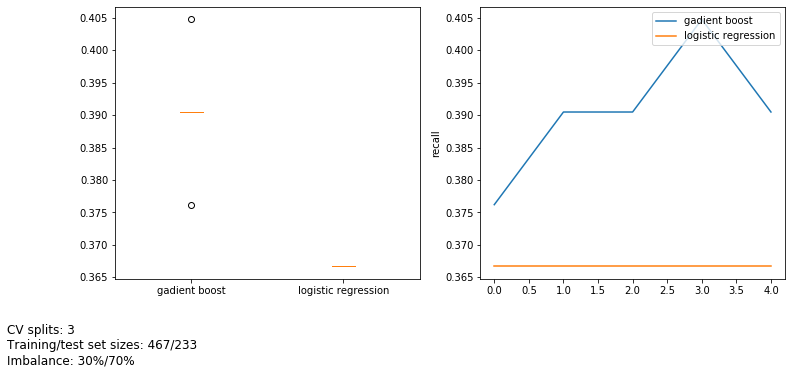

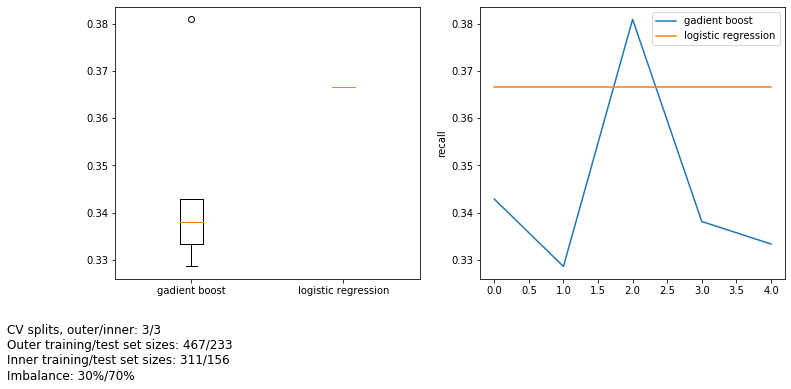

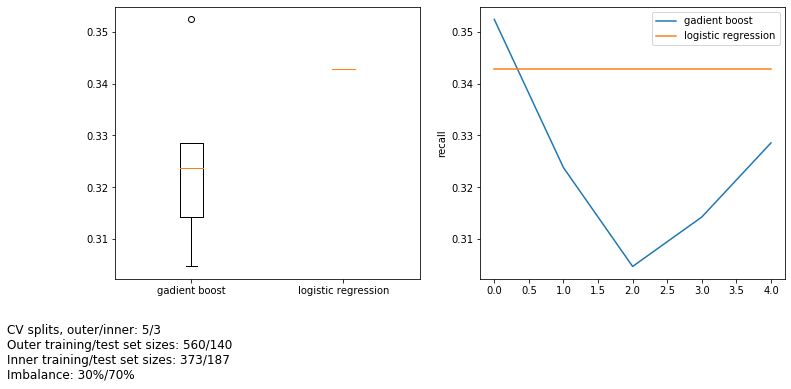

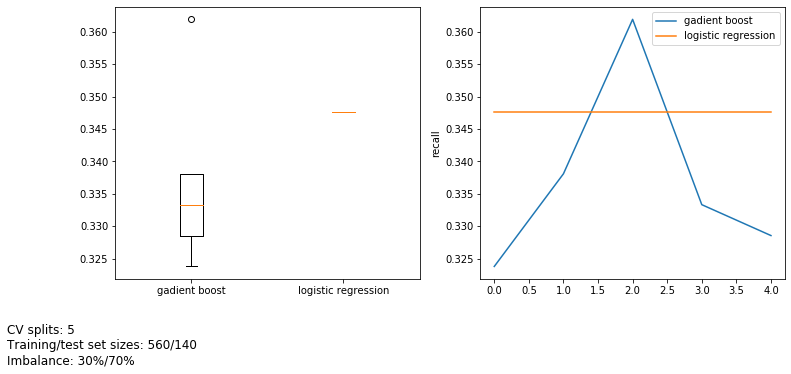

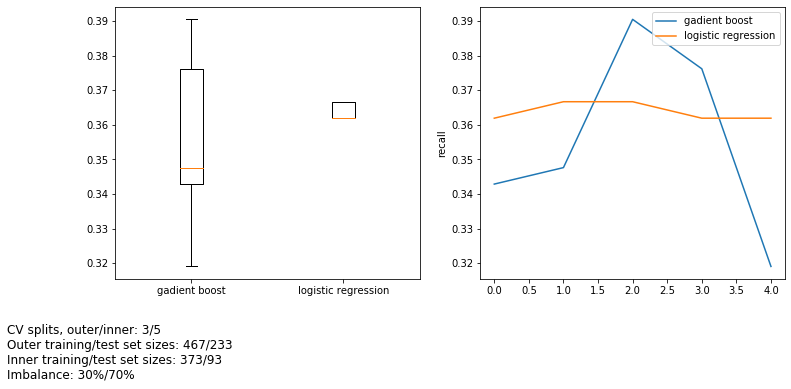

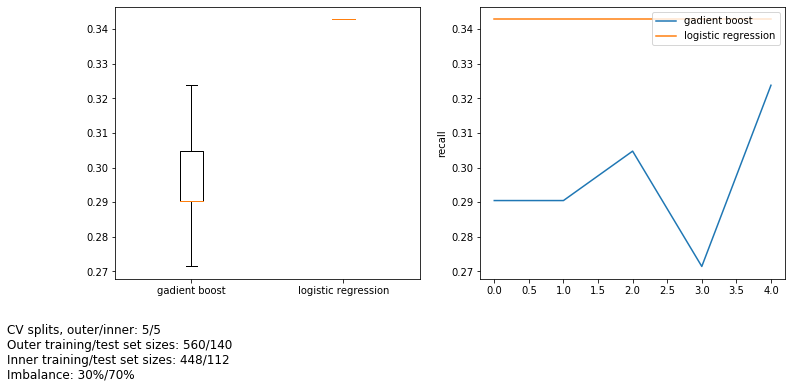

In [11]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
num_trials = 5
randcv_budget = 30
scoring = 'recall'

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### Random undersampling

In [12]:
ests = [('gadient boost',
         pipe.pca().steps + [('rus', RandomUnderSampler()), ('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.pca().steps + [('rus', RandomUnderSampler()), ('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 2min 37s, sys: 1.78 s, total: 2min 39s
Wall time: 13min 38s


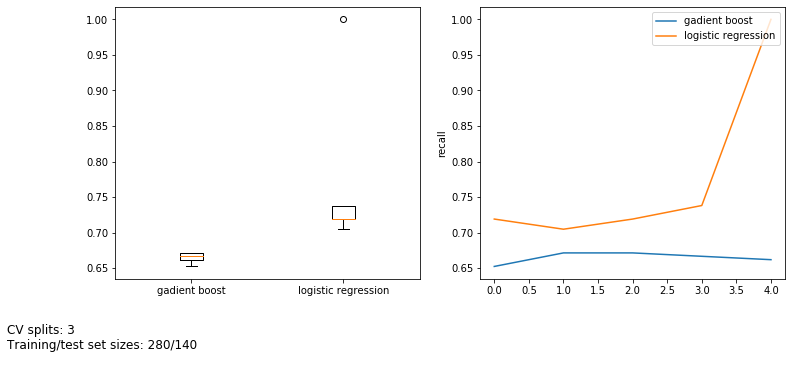

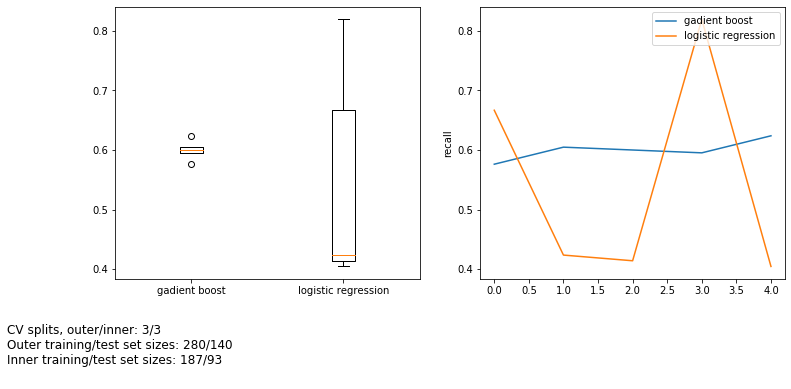

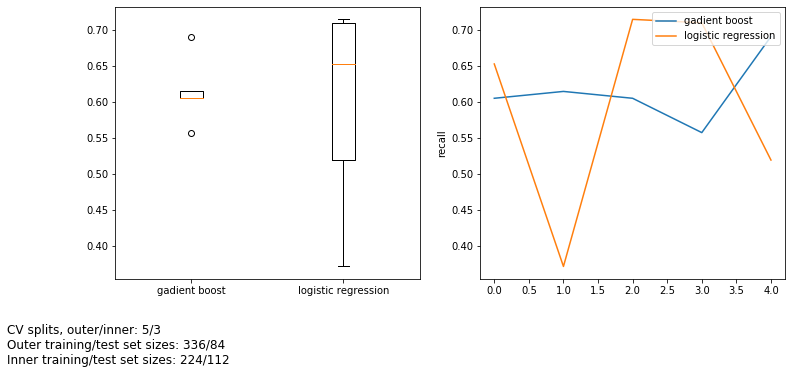

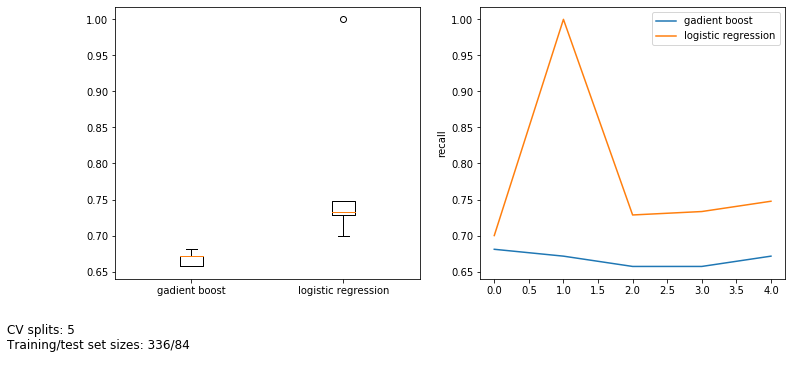

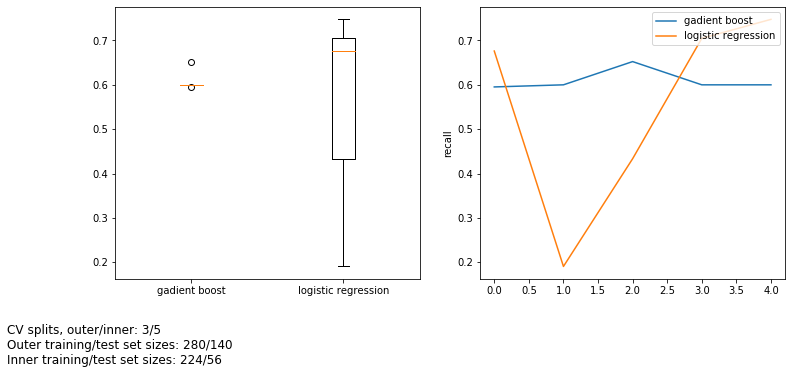

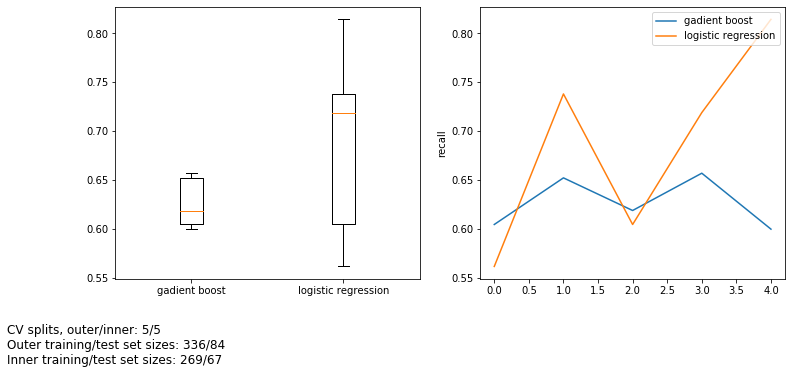

In [13]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
num_trials = 5
randcv_budget = 30
scoring = 'recall'

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### EasyEnsemble

In [14]:
ests = [('gadient boost',
         pipe.pca().steps + [('easy', EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier()))],
         {'easy__base_estimator__max_depth': randint(3, 8),
          'easy__base_estimator__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.pca().steps + [('easy', EasyEnsembleClassifier(base_estimator=LogisticRegression(solver='saga', penalty='elasticnet')))],
         {'easy__base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'easy__base_estimator__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

CPU times: user 5min 4s, sys: 1.81 s, total: 5min 6s
Wall time: 1h 43min 58s


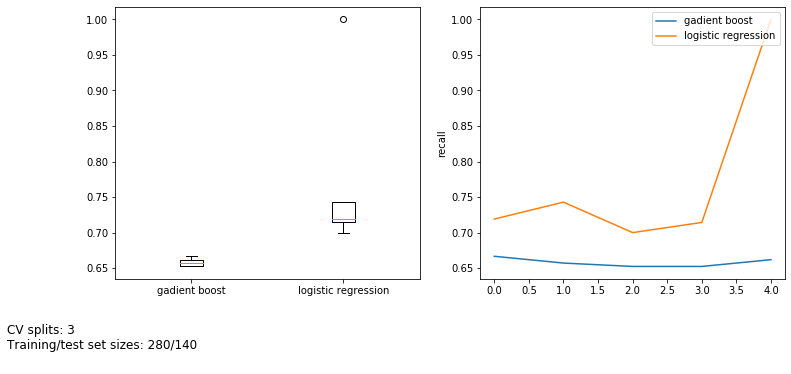

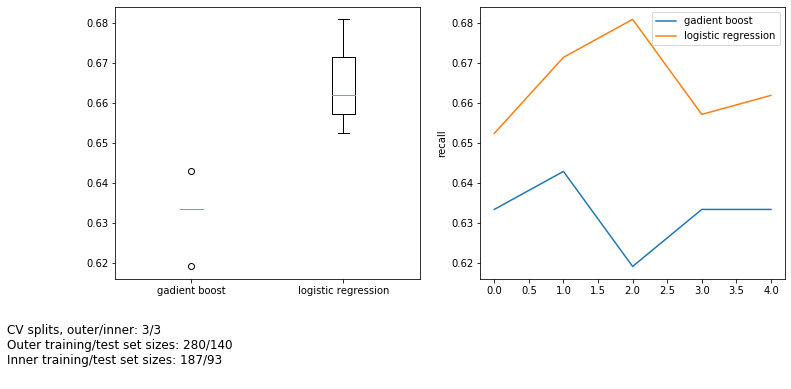

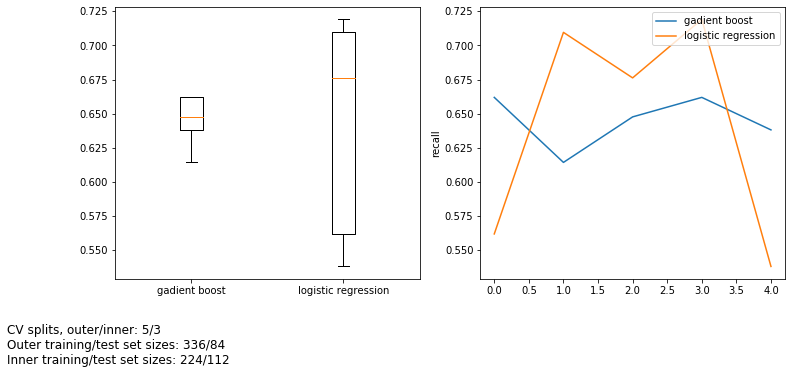

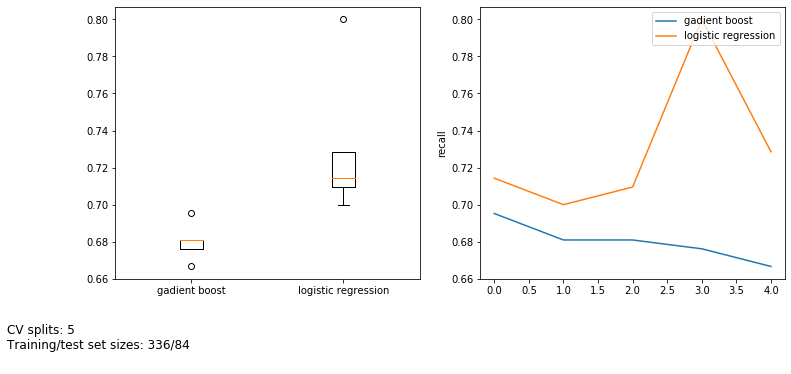

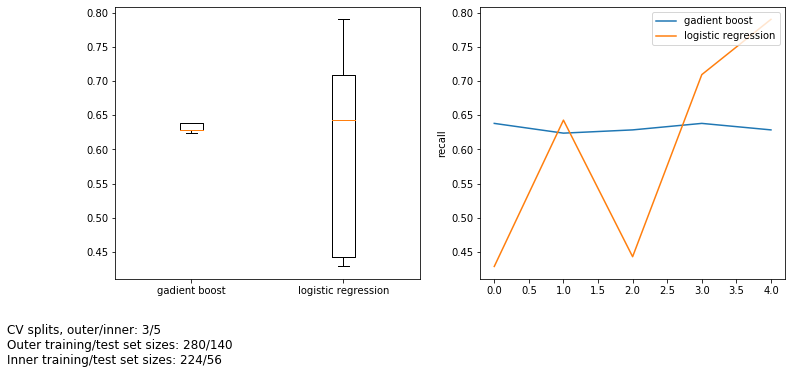

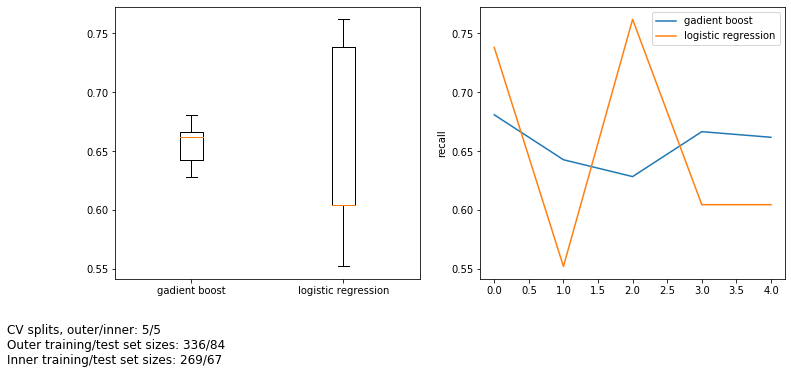

In [15]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
scoring = 'recall'
num_trials = 5
randcv_budget = 30

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

## MCA

### Imbalanced

In [19]:
ests = [('gadient boost',
         pipe.mca().steps + [('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.mca().steps + [('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = False

In [ ]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
scoring = 'recall'
num_trials = 5
randcv_budget = 30

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### Random undersampling

In [21]:
ests = [('gadient boost',
         pipe.mca().steps + [('rus', RandomUnderSampler()), ('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.mca().steps + [('rus', RandomUnderSampler()), ('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

CPU times: user 4min 57s, sys: 2.88 s, total: 5min
Wall time: 36min 45s


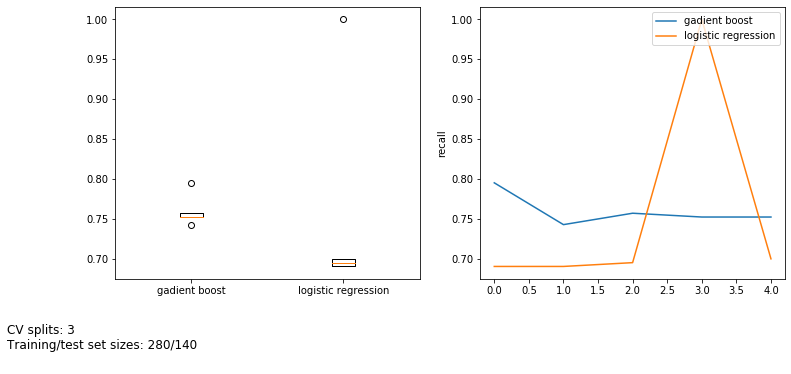

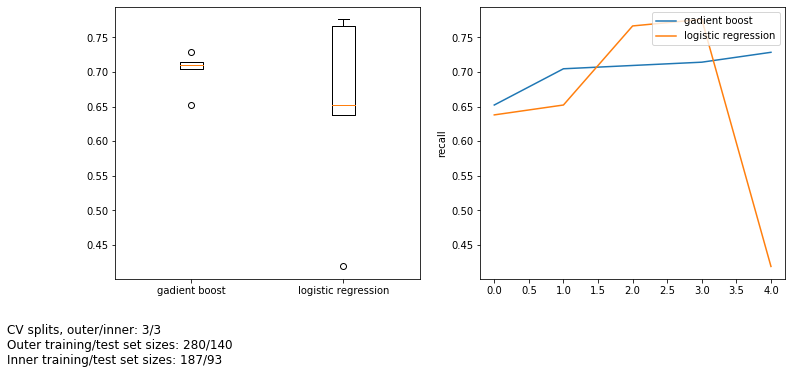

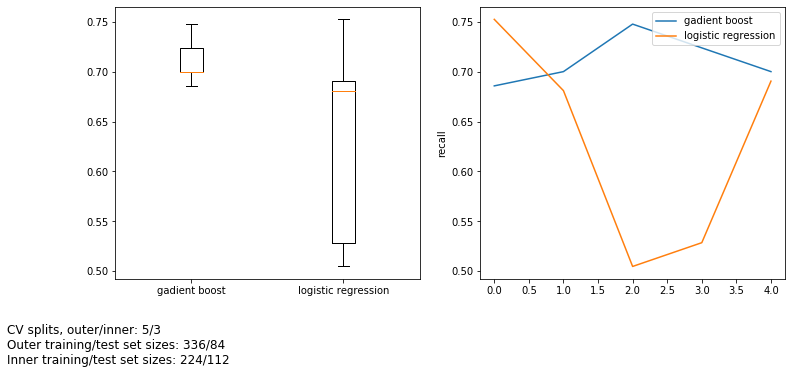

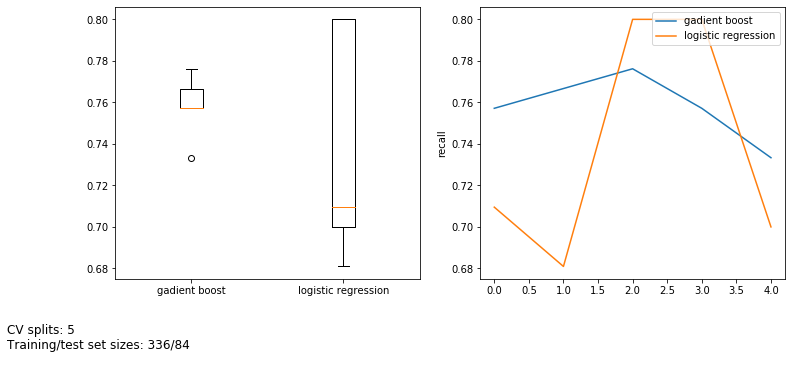

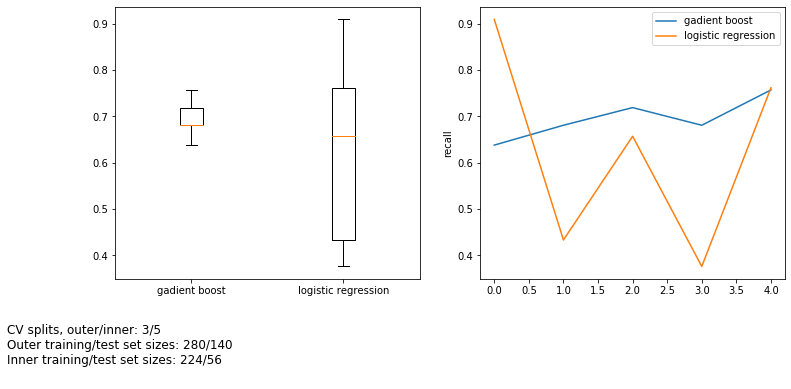

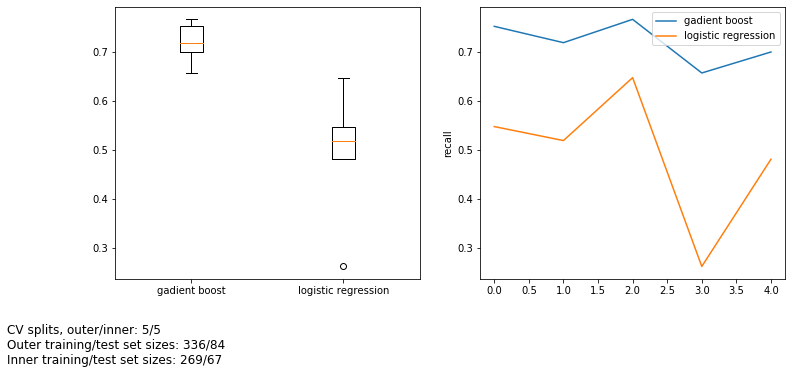

In [24]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
num_trials = 5
randcv_budget = 30
scoring = 'recall'

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for inner_splits, outer_splits in product(inner, outer):
        results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
        visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### EasyEnsemble

In [14]:
ests = [('gadient boost',
         pipe.mca().steps + [('easy', EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier()))],
         {'easy__base_estimator__max_depth': randint(3, 8),
          'easy__base_estimator__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.mca().steps + [('easy', EasyEnsembleClassifier(base_estimator=LogisticRegression(solver='saga', penalty='elasticnet')))],
         {'easy__base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'easy__base_estimator__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

In [ ]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
scoring = 'recall'
num_trials = 5
randcv_budget = 30

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

## Plain

### Imbalanced

In [19]:
ests = [('gadient boost',
         pipe.plain().steps + [('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.plain().steps + [('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = False

/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pinguin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_ite

CPU times: user 2min 24s, sys: 1.51 s, total: 2min 25s
Wall time: 13min 7s


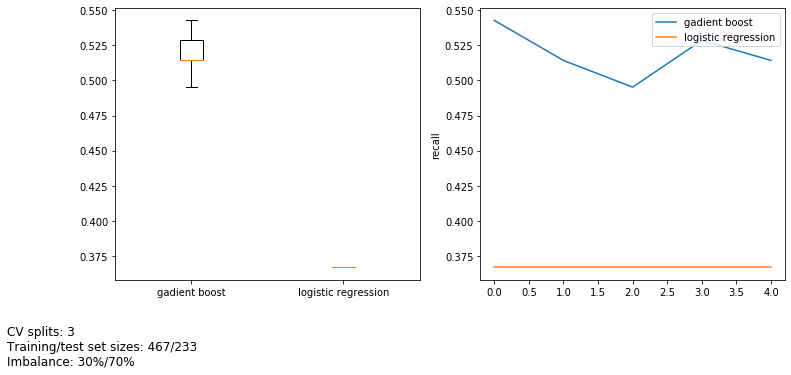

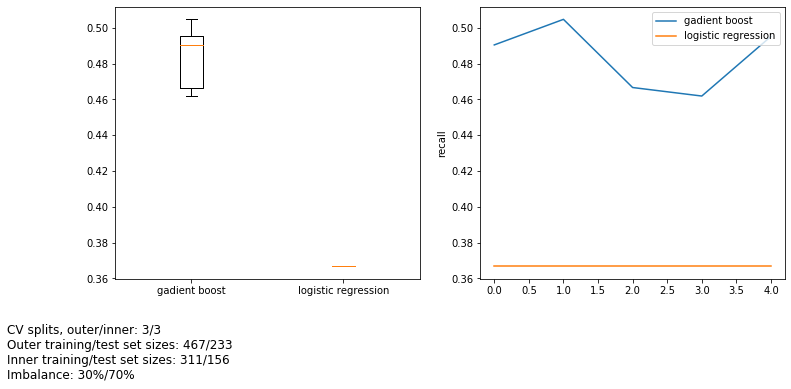

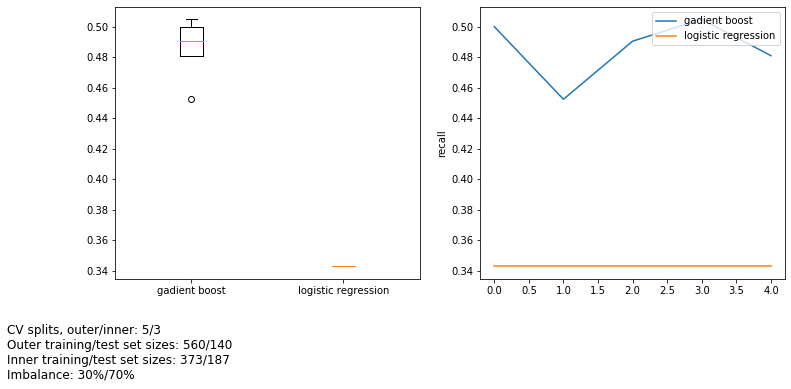

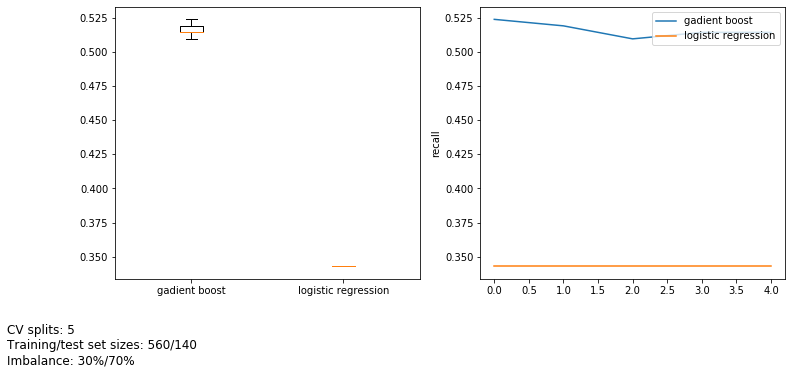

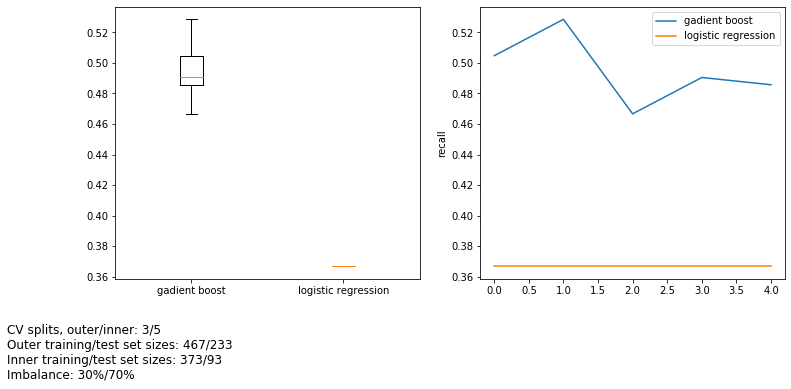

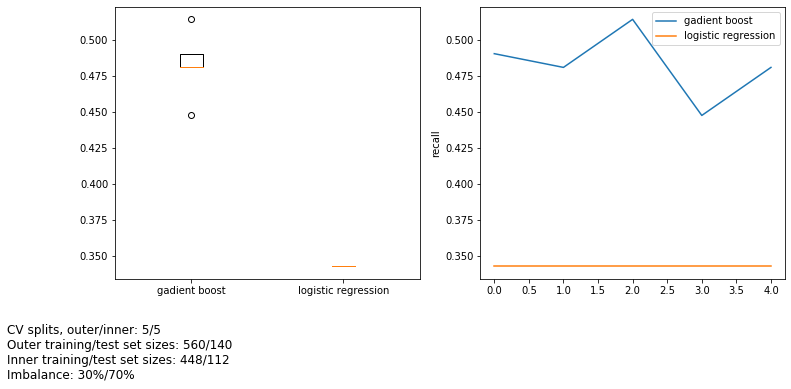

In [20]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
scoring = 'recall'
num_trials = 5
randcv_budget = 30

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### Random undersampling

In [12]:
ests = [('gadient boost',
         pipe.plain().steps + [('rus', RandomUnderSampler()), ('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.plain().steps + [('rus', RandomUnderSampler()), ('lr', LogisticRegression(solver='saga', penalty='elasticnet'))],
         {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'lr__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

In [ ]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
num_trials = 5
randcv_budget = 30
scoring = 'recall'

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### EasyEnsemble

In [14]:
ests = [('gadient boost',
         pipe.pca().steps + [('easy', EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier()))],
         {'easy__base_estimator__max_depth': randint(3, 8),
          'easy__base_estimator__learning_rate': uniform(0, 1)}),
        ('logistic regression',
         pipe.pca().steps + [('easy', EasyEnsembleClassifier(base_estimator=LogisticRegression(solver='saga', penalty='elasticnet')))],
         {'easy__base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'easy__base_estimator__l1_ratio': [0, 0.001, 0.01, 0.1, 1]})]
balance = True

In [ ]:
%%time

inner = [3, 5]
outer = [None, 3, 5]
scoring = 'recall'
num_trials = 5
randcv_budget = 30

for inner_splits, outer_splits in product(inner, outer):
    results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
    visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### Final model refinement

In [26]:
ests = [('gadient boost',
         pipe.mca().steps + [('rus', RandomUnderSampler()), ('gboost', XGBClassifier())],
         {'gboost__max_depth': randint(3, 8),
          'gboost__learning_rate': uniform(0, 1)})]
balance = True

CPU times: user 50.1 s, sys: 505 ms, total: 50.6 s
Wall time: 7min 19s


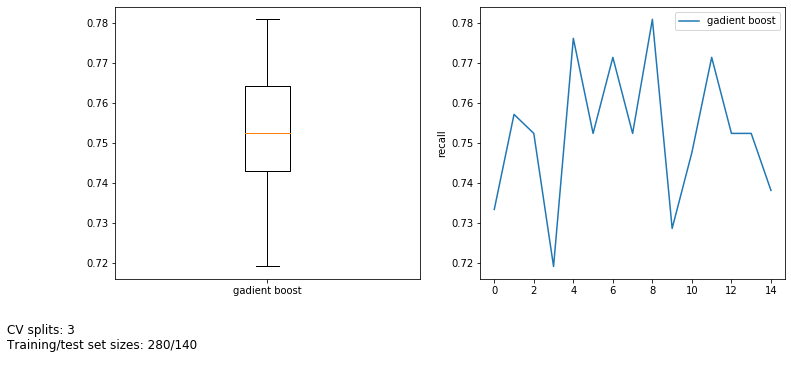

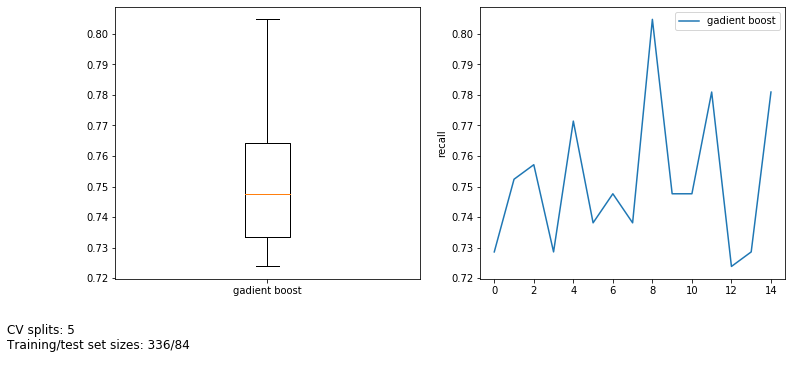

In [27]:
%%time

inner = [3, 5]
outer = [None]
num_trials = 15
randcv_budget = 30
scoring = 'recall'

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for inner_splits, outer_splits in product(inner, outer):
        results = compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits, randcv_budget)
        visualise_scores(results, y, scoring, balance, inner_splits, outer_splits)

### Bagged undersampling (handmade)

In [9]:
def compare_classifiers(X, y, ests, scoring, num_trials, inner_splits, outer_splits=None, balance=False):

    results = []

    # For every model type
    for label, est, p_grid in ests:
        cv_scores = np.empty(num_trials, dtype=float)
        cv_estimators = np.empty(num_trials, dtype=object)

        # Assess stability of the model selection procedure
        for i in range(num_trials): # RepeatedKFold? RepeatedStratifiedKFold?

            if balance:
                balance_scores = []
                balance_estimators = []
                
                # Actually bagging here
                # TODO: imblearn.ensemble.EasyEnsembleClassifier
                for _ in range(5):

                    # TODO: use imblearn.under_sampling
                    X_prep, y_prep = downsample(X, y)
                    cv_score, cv_estimator = nested_cv(X_prep, y_prep, est, p_grid, scoring, inner_splits, outer_splits)
                    balance_scores += [cv_score]
                    balance_estimators += [cv_estimator]
                
                cv_score = np.mean(balance_scores)
                cv_estimator = AggregatedClassifier(balance_estimators, np.mean)
            else:
                cv_score, cv_estimator = nested_cv(X, y, est, p_grid, scoring, inner_splits, outer_splits)

            cv_scores[i] = cv_score
            cv_estimators[i] = cv_estimator
        results += [(label, cv_scores, cv_estimators)]

    # Plot the scores distribution to assess the above model selection process stability (variance)
    visualise_scores(y, inner_splits, outer_splits, results, scoring, balance)

## Previous

### Logistic regression

In [7]:
# %%time

# Train
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

models_lr = list(train(X, y, lr, params, 100))


True Positives: 70.3%
True Negatives: 68.6%
False Positives: 31.4%
False Negatives: 29.7%

Accuracy: 69.3
Precision: 69.4
Recall: 70.3
Area under the curve: 0.762


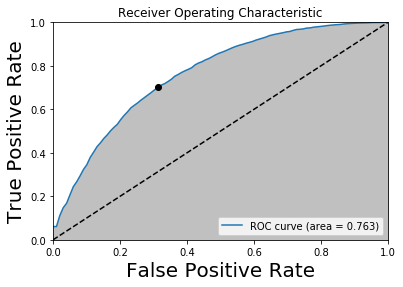

In [112]:
# Visualize mean metrics
metrics_lr = list(calculate_metrics(models_lr, 0.5))
visualize_metrics(metrics_lr)


True Positives: 88.7%
True Negatives: 77.0%
False Positives: 23.0%
False Negatives: 11.3%

Accuracy: 82.4
Precision: 76.4
Recall: 88.7
Area under the curve: 0.890


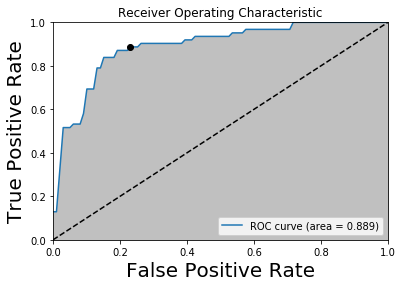

In [113]:
# Get the best classifier
best_ix = np.argmax([m['roc_auc'] for m in metrics_lr])
best_estimator = models_lr[best_ix]['estimator']
visualize_metrics([metrics_lr[best_ix]])

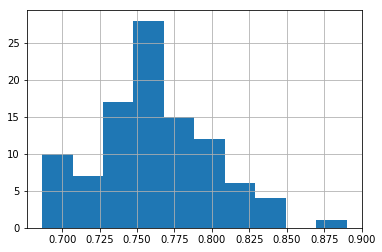

In [114]:
# Build classifier distribution
pd.Series([m['roc_auc'] for m in metrics_lr]).hist();

In [115]:
models_lr[best_ix]['estimator'].best_params_

{'C': 1}


True Positives: 77.0%
True Negatives: 70.5%
False Positives: 29.5%
False Negatives: 23.0%

Accuracy: 72.4
Precision: 52.3
Recall: 77.0
Area under the curve: 0.747


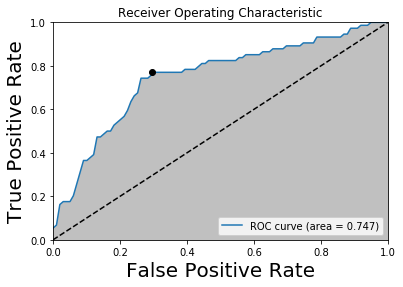

In [116]:
# Measure performance on the test set
best_model_lr = [{'estimator': best_estimator,
                  'y_test': y_test,
                  'y_pred_proba': best_estimator.predict_proba(X_test)[:, 1]}]

# Visualize the metrics
best_metrics_lr = list(calculate_metrics(best_model_lr, 0.5))
visualize_metrics(best_metrics_lr)

The model seems to overfit a lot at the CV stage.

---

### Gradient boosting

In [17]:
# %%time

# Train
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
params = {'loss': ['exponential', 'deviance'],
          'n_estimators': [100, 200],
          'warm_start': [True],
          'max_depth': [4, 5]}
models_gb = list(train(X, y, gb, params, 100))


True Positives: 72.5%
True Negatives: 70.3%
False Positives: 29.7%
False Negatives: 27.5%

Accuracy: 71.2
Precision: 70.4
Recall: 72.5
Area under the curve: 0.790


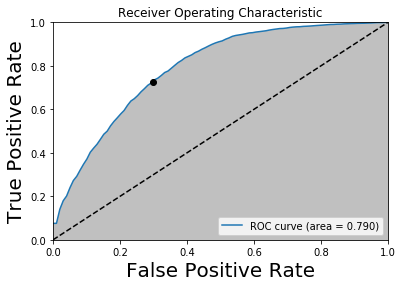

In [118]:
# Visualize mean metrics
metrics_gb = list(calculate_metrics(models_gb, 0.5))
visualize_metrics(metrics_gb)

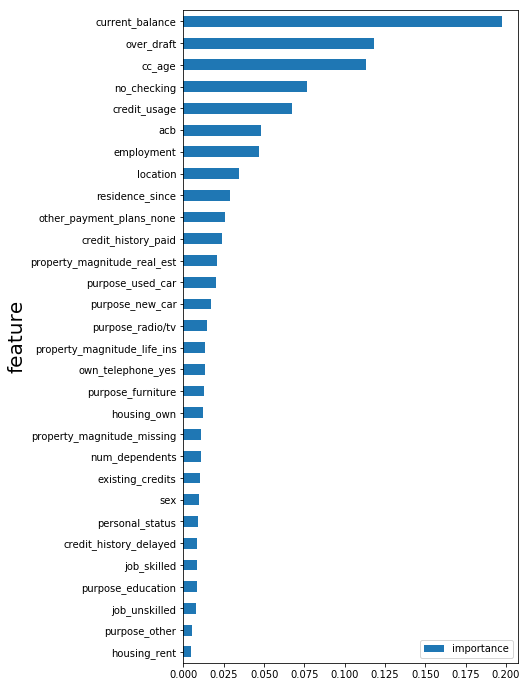

In [119]:
# Get feature importance
feature_imp = pd.DataFrame({'feature': list(X), 'importance': [round(x, 5) for x in np.mean([y['estimator'].best_estimator_.feature_importances_ for y in models_gb], axis=0)]})
feature_imp.set_index('feature', inplace=True)
feature_imp = feature_imp.sort_values(by='importance', ascending=True)
feature_imp.plot.barh(figsize=(6, 12));


True Positives: 83.3%
True Negatives: 78.9%
False Positives: 21.1%
False Negatives: 16.7%

Accuracy: 80.9
Precision: 75.8
Recall: 83.3
Area under the curve: 0.899


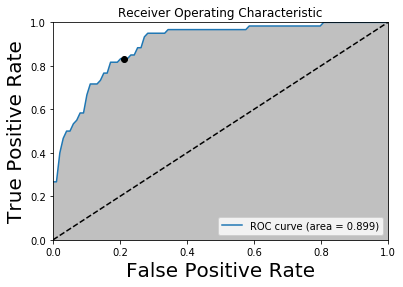

In [120]:
# Get the best classifier
best_ix = np.argmax([m['roc_auc'] for m in metrics_gb])
best_estimator = models_gb[best_ix]['estimator']
visualize_metrics([metrics_gb[best_ix]])

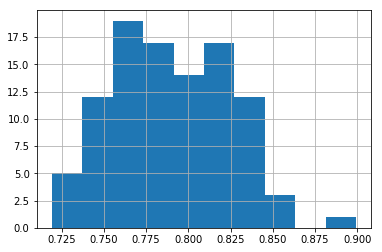

In [121]:
pd.Series([m['roc_auc'] for m in metrics_gb]).hist();

In [122]:
models_gb[best_ix]['estimator'].best_params_

{'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200, 'warm_start': True}


True Positives: 73.0%
True Negatives: 62.5%
False Positives: 37.5%
False Negatives: 27.0%

Accuracy: 65.6
Precision: 45.0
Recall: 73.0
Area under the curve: 0.753


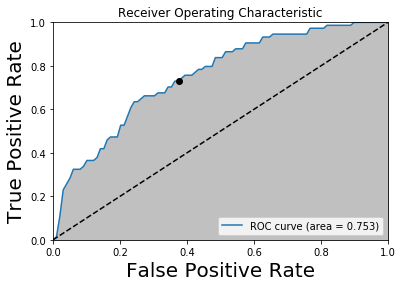

In [123]:
# Measure performance on the test set
best_model_gb = [{'estimator': best_estimator,
                  'y_test': y_test,
                  'y_pred_proba': best_estimator.predict_proba(X_test)[:, 1]}]

# Visualize the metrics
best_metrics_gb = list(calculate_metrics(best_model_gb, 0.5))
visualize_metrics(best_metrics_gb)

The model seems to overfit a lot at the CV stage.


True Positives: 68.5%
True Negatives: 67.4%
False Positives: 32.6%
False Negatives: 31.5%

Accuracy: 67.7
Precision: 67.8
Recall: 68.5
AUC: 0.745
AUC 99% bootstrap CI: [0.741, 0.748]


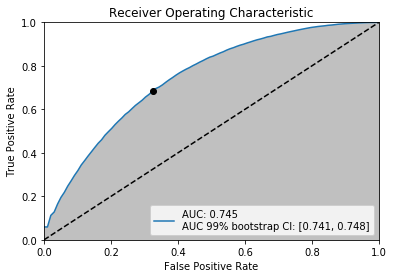

In [298]:
# Visualize mean metrics
metrics_lr = aggregate_metrics(list(collect_metrics(models_lr, 0.5)))
visualize_metrics(metrics_lr)

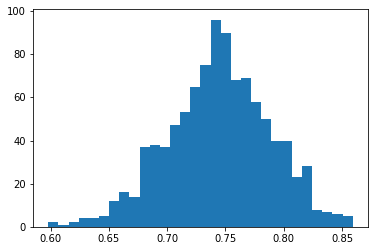

In [182]:
plt.hist([m['roc_auc'] for m in collected_metrics], bins=30);

In [301]:
from sklearn.utils import resample

a = [m['roc_auc'] for m in collected_metrics]
print(np.mean(a))

n = 1000
a_mean = np.zeros(n)
for i in range(n):
    a_mean[i] = np.mean(resample(a, replace=True))

0.7445688193697068


[0.74346921 0.7468781 ]
(0.7418464810454733, 0.7472911576939402)


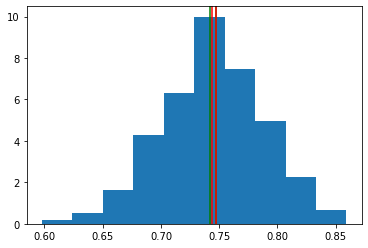

In [317]:
# Bootstrap vs regular CI

a_mean = a
alpha = 0.95
d_f = len(a) - 1
loc = np.mean(a_mean)
scale = st.sem(a_mean, ddof=1)

# q = np.quantile(a, [(1 - alpha)/2, (1 + alpha)/2])
# print(q)

q_mean = np.quantile(a_mean, [(1 - alpha/np.sqrt(n))/2, (1 + alpha/np.sqrt(n))/2])
print(q_mean)

ci = st.t.interval(alpha=alpha, df=d_f, loc=loc, scale=scale)
print(ci)

# plt.hist(a, density=True)
# plt.axvline(np.mean(q[0]), color='g')
# plt.axvline(np.mean(q[1]), color='g')

# plt.hist(a, density=True)
plt.axvline(np.mean(ci[0]), color='g')
plt.axvline(np.mean(ci[1]), color='g')
plt.hist(a_mean, density=True)
plt.axvline(np.mean(q_mean[0]), color='r')
plt.axvline(np.mean(q_mean[1]), color='r');


True Positives: 60.0%
True Negatives: 71.0%
False Positives: 29.0%
False Negatives: 40.0%

Accuracy: 67.7
Precision: 47.0
Recall: 60.0
AUC: 0.730


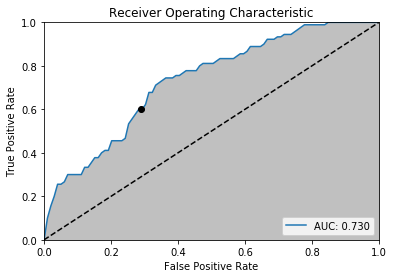

In [297]:
# Measure performance of the aggregated classifier on the test set
aggregated = AggregatedClassifier(map(lambda m: m['estimator'], models_lr),
                                  np.mean,
                                  axis=0)
best_model_lr = [{'y_test': y_test,
                  'y_pred_proba': aggregated.predict_proba(X_test)}]

# Visualize the metrics
best_metrics_lr = aggregate_metrics(list(collect_metrics(best_model_lr, 0.5)))
visualize_metrics(best_metrics_lr)

In [101]:
best_metrics_lr

[{'tn': 149,
  'fp': 61,
  'fn': 36,
  'tp': 54,
  'tpr': 60.0,
  'tnr': 71.0,
  'fpr': 29.0,
  'fnr': 40.0,
  'acc': 67.7,
  'precision': 47.0,
  'recall': 60.0,
  'tpr_roc': array([0.        , 0.1       , 0.15555556, 0.2       , 0.25555556,
         0.25555556, 0.26666667, 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.33333333, 0.33333333, 0.35555556,
         0.37777778, 0.37777778, 0.4       , 0.41111111, 0.41111111,
         0.45555556, 0.45555556, 0.45555556, 0.45555556, 0.46666667,
         0.53333333, 0.55555556, 0.57777778, 0.6       , 0.6       ,
         0.62222222, 0.67777778, 0.67777778, 0.71111111, 0.72222222,
         0.73333333, 0.74444444, 0.74444444, 0.74444444, 0.75555556,
         0.75555556, 0.76666667, 0.77777778, 0.77777778, 0.77777778,
         0.77777778, 0.8       , 0.81111111, 0.81111111, 0.81111111,
         0.81111111, 0.82222222, 0.83333333, 0.83333333, 0.83333333,
         0.83333333, 0.83333333, 0.84444444, 0.85555556, 0.85555556

### Gradient boosting

In [28]:
# %%time

# Train
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
params = {'loss': ['exponential', 'deviance'],
          'n_estimators': [100, 200],
          'warm_start': [True],
          'max_depth': [4, 5]}
models_gb = list(train(X, y, gb, params, 100))


True Positives: 68.4%
True Negatives: 68.7%
False Positives: 31.3%
False Negatives: 31.6%

Accuracy: 68.3
Precision: 68.7
Recall: 68.4
Area under the curve: 0.764


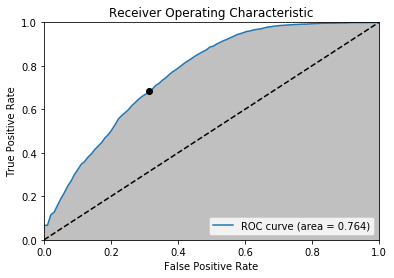

In [30]:
# Visualize mean metrics
metrics_gb = list(calculate_metrics(models_gb, 0.5))
visualize_metrics(metrics_gb)

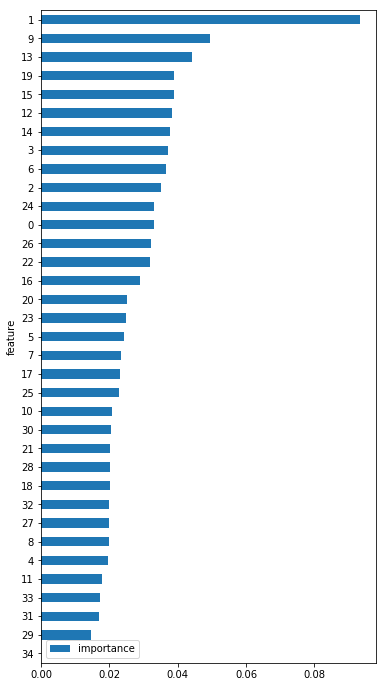

In [31]:
# Get feature importance
feature_imp = pd.DataFrame({'feature': list(X), 'importance': [round(x, 5) for x in np.mean([y['estimator'].best_estimator_.feature_importances_ for y in models_gb], axis=0)]})
feature_imp.set_index('feature', inplace=True)
feature_imp = feature_imp.sort_values(by='importance', ascending=True)
feature_imp.plot.barh(figsize=(6, 12));


True Positives: 71.2%
True Negatives: 83.3%
False Positives: 16.7%
False Negatives: 28.8%

Accuracy: 77.0
Precision: 82.5
Recall: 71.2
Area under the curve: 0.870


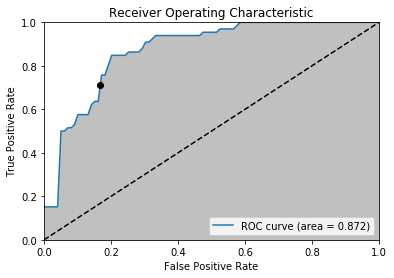

In [32]:
# Get the best classifier
best_ix = np.argmax([m['roc_auc'] for m in metrics_gb])
best_estimator = models_gb[best_ix]['estimator']
visualize_metrics([metrics_gb[best_ix]])


True Positives: 65.6%
True Negatives: 61.9%
False Positives: 38.1%
False Negatives: 34.4%

Accuracy: 63.0
Precision: 42.4
Recall: 65.6
Area under the curve: 0.701


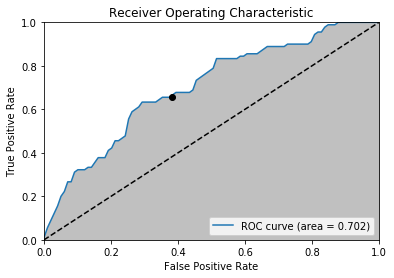

In [33]:
# Measure performance on the test set
best_model_gb = [{'estimator': best_estimator,
                  'y_test': y_test,
                  'y_pred_proba': best_estimator.predict_proba(X_test)[:, 1]}]

# Visualize the metrics
best_metrics_gb = list(calculate_metrics(best_model_gb, 0.5))
visualize_metrics(best_metrics_gb)

## Plain

In [84]:
import pipe

# Train
df = pd.read_csv(r'data/train.csv')
y = df['class'].map({'good': 0, 'bad': 1})

df = df.drop('class', axis=1)
plain = pipe.plain().fit(df)
X = pd.DataFrame(plain.transform(df))

# Test
df_test = pd.read_csv(r'data/test.csv')
y_test = df_test['class'].map({'good': 0, 'bad': 1})

df_test = df_test.drop('class', axis=1)
X_test = pd.DataFrame(plain.transform(df_test))

### Logistic regression

In [85]:
# %%time

# Train
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', penalty='elasticnet')
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'l1_ratio': [0.001, 0.01, 0.1, 1]}

models_lr = list(train(X, y, lr, params, 100))


True Positives: 68.2%
True Negatives: 68.0%
False Positives: 32.0%
False Negatives: 31.8%

Accuracy: 67.9
Precision: 68.2
Recall: 68.2
Area under the curve: 0.742


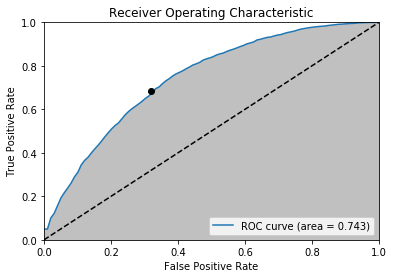

In [86]:
# Visualize mean metrics
metrics_lr = list(calculate_metrics(models_lr, 0.5))
visualize_metrics(metrics_lr)


True Positives: 72.1%
True Negatives: 81.5%
False Positives: 18.5%
False Negatives: 27.9%

Accuracy: 77.0
Precision: 78.6
Recall: 72.1
Area under the curve: 0.844


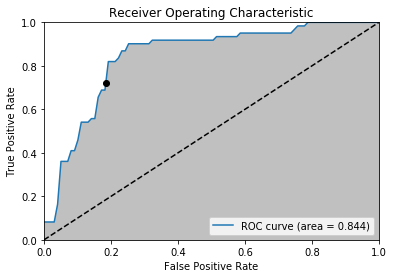

In [87]:
# Get the best classifier
best_ix = np.argmax([m['roc_auc'] for m in metrics_lr])
best_estimator = models_lr[best_ix]['estimator']
visualize_metrics([metrics_lr[best_ix]])


True Positives: 55.6%
True Negatives: 70.0%
False Positives: 30.0%
False Negatives: 44.4%

Accuracy: 65.7
Precision: 44.2
Recall: 55.6
Area under the curve: 0.714


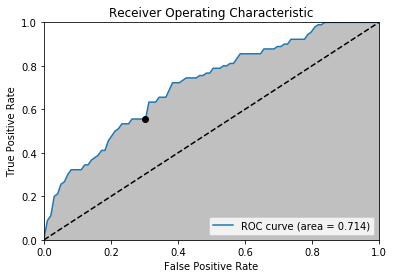

In [88]:
# Measure performance on the test set
best_model_lr = [{'estimator': best_estimator,
                  'y_test': y_test,
                  'y_pred_proba': best_estimator.predict_proba(X_test)[:, 1]}]

# Visualize the metrics
best_metrics_lr = list(calculate_metrics(best_model_lr, 0.5))
visualize_metrics(best_metrics_lr)

### Gradient boosting

In [29]:
# %%time

# Train
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
params = {'loss': ['exponential', 'deviance'],
          'n_estimators': [100, 200],
          'warm_start': [True],
          'max_depth': [4, 5]}
models_gb = list(train(X, y, gb, params, 100))


True Positives: 69.1%
True Negatives: 69.5%
False Positives: 30.5%
False Negatives: 30.9%

Accuracy: 69.1
Precision: 69.6
Recall: 69.1
Area under the curve: 0.765


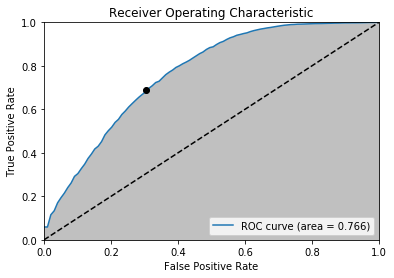

In [24]:
# Visualize mean metrics
metrics_gb = list(calculate_metrics(models_gb, 0.5))
visualize_metrics(metrics_gb)

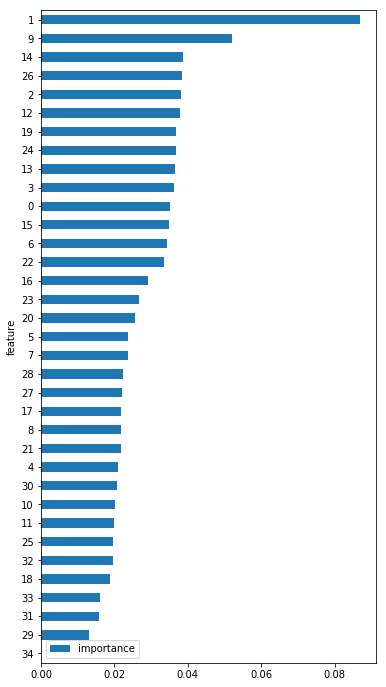

In [25]:
# Get feature importance
feature_imp = pd.DataFrame({'feature': list(X), 'importance': [round(x, 5) for x in np.mean([y['estimator'].best_estimator_.feature_importances_ for y in models_gb], axis=0)]})
feature_imp.set_index('feature', inplace=True)
feature_imp = feature_imp.sort_values(by='importance', ascending=True)
feature_imp.plot.barh(figsize=(6, 12));


True Positives: 80.4%
True Negatives: 78.6%
False Positives: 21.4%
False Negatives: 19.6%

Accuracy: 79.4
Precision: 75.0
Recall: 80.4
Area under the curve: 0.881


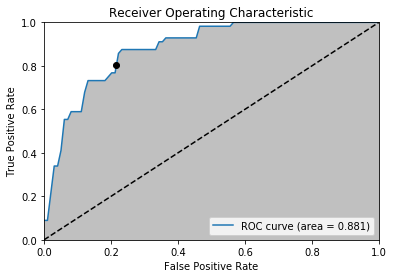

In [26]:
# Get the best classifier
best_ix = np.argmax([m['roc_auc'] for m in metrics_gb])
best_estimator = models_gb[best_ix]['estimator']
visualize_metrics([metrics_gb[best_ix]])


True Positives: 53.3%
True Negatives: 43.8%
False Positives: 56.2%
False Negatives: 46.7%

Accuracy: 46.7
Precision: 28.9
Recall: 53.3
Area under the curve: 0.504


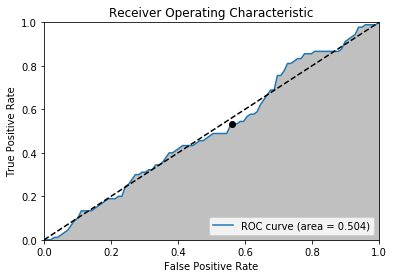

In [27]:
# Measure performance on the test set
best_model_gb = [{'estimator': best_estimator,
                  'y_test': y_test,
                  'y_pred_proba': best_estimator.predict_proba(X_test)[:, 1]}]

# Visualize the metrics
best_metrics_gb = list(calculate_metrics(best_model_gb, 0.5))
visualize_metrics(best_metrics_gb)

---

### Linear discriminant analysis

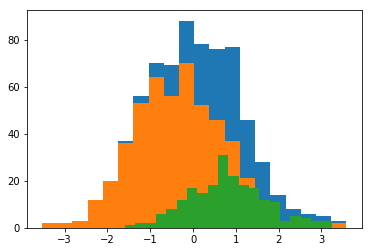

In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)

plt.hist(X_lda, bins=20)
plt.hist(X_lda[y == 0], bins=20)
plt.hist(X_lda[y == 1], bins=20);

Automatically created module for IPython interactive environment
best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
best n_components by PCA CV = 35
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 38


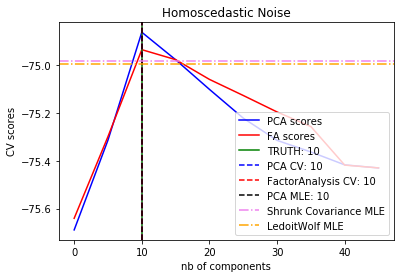

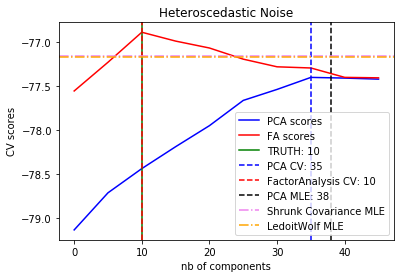

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X, cv=5)))
        fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages}, cv=5)
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X, cv=5))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X, cv=5))


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

### Manifold projections

In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from sklearn import manifold

def manifold_projections(X, color):
    n_neighbors = 10
    n_components = 2

    fig = plt.figure(figsize=(15, 8))

    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('Isomap')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('MDS')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('SpectralEmbedding')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    tsne = manifold.TSNE(n_components=n_components, init='pca')
    Y = tsne.fit_transform(X)
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='Dark2', alpha=0.5)
    plt.title('t-SNE')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

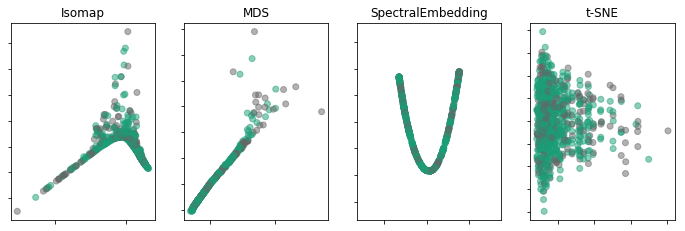

In [64]:
manifold_projections(prep, output)

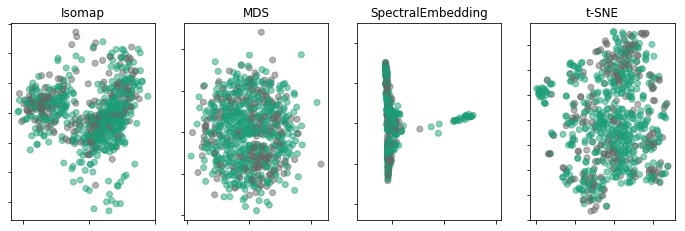

In [65]:
manifold_projections(X_mca, X_mca.index)

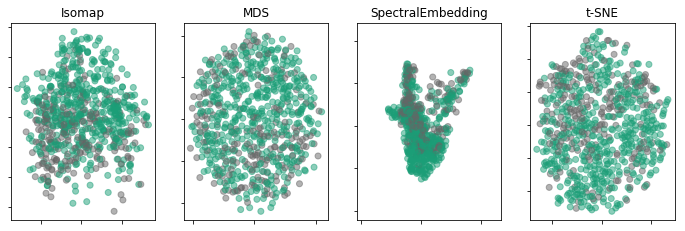

In [66]:
manifold_projections(X_famd, X_famd.index)

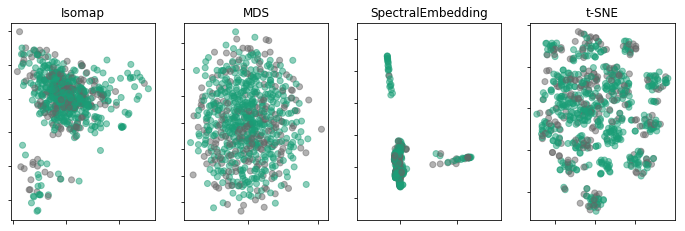

In [68]:
manifold_projections(pd.DataFrame(X_fa), output)